--------------------------------------------------------------------------------
Travel time calculation using ModPathWell class, combined with 'mbo removal'
--------------------------------------------------------------------------------

Example to calculate the travel time distribution per geological layer for a 
.. phreatic scheme, and to calculate the removal of microbial organisms (mbo). 
.. For an extensive description of the steps, see the basic example [AnalyticalWell & OMP removal](https://github.com/KWR-Water/sutra2/blob/main/research/Tutorial_AW_omp_removal.ipynb).

________________________________________

Import packages
-----------------

First we import the necessary python packages

In [88]:
import pandas as pd
from pathlib import Path
from set_cwd_to_project_root import project_root

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pandas import read_csv
from pandas import read_excel
import math
from scipy.special import kn as besselk
import sutra2.Analytical_Well as AW
import sutra2.ModPath_Well as mpw
import sutra2.Transport_Removal as TR

import warnings 
warnings.filterwarnings(action= 'ignore')

# get directory of this file
path = Path(project_root)
print(path)

%load_ext autoreload
%autoreload 2

d:\Sutra2_tool\sutra2\research
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Step 1: Define the HydroChemicalSchematisation
-----------------------------------------------
The first step is to define the hydrogeochemistry of the system using the HydroChemicalSchematisation class.

In [89]:
# Lets start with a simple example defining a HydroChemicalSchematisation object for a phreatic aquifer:
phreatic_schematisation = AW.HydroChemicalSchematisation(schematisation_type='phreatic',
                                                    computation_method = 'modpath',
                                                    well_discharge=-7500, #m3/day
                                                    recharge_rate=0.0008, #m/day
                                                    thickness_vadose_zone_at_boundary=5, #m
                                                    thickness_shallow_aquifer=10,  #m
                                                    thickness_target_aquifer=40, #m
                                                    hor_permeability_target_aquifer=35, #m/day
                                                    redox_vadose_zone='anoxic',
                                                    redox_shallow_aquifer='anoxic',
                                                    redox_target_aquifer='deeply_anoxic',
                                                    pH_target_aquifer=7.,
                                                    temp_water=11.,
                                                    diffuse_input_concentration = 100, #ug/L
                                                    )

Then, we create a ModpathWell object for the HydroChemicalSchematisation object that we just made.
The ModpathWell object requires a dictionary of the subsurface schematisation and a set of boundary conditions the numerical model has to abide by in calculating flow velocity and direction of flow.

In [90]:
phreatic_schematisation.make_dictionary()

In [91]:
# Set workspace
workspace = os.path.join(path, "mpw_mboremoval")
if not os.path.exists(workspace):
    os.makedirs(workspace)

Step 2: Run the ModpathWell class
-----------------------------------
Next we create an ModpathWell object for the HydroChemicalSchematisation object we just made.
The data files will be stored in location workspace using a given modelname.

In [92]:
modpath_phrea = mpw.ModPathWell(phreatic_schematisation,
                            workspace = workspace,
                            modelname = "phreatic")

Now we run the Modpath model, which numerically calculates the flow in the subsurface using the 
'schematisation' dictionary stored in the HydroChemicalSchematisation object. By default the model will calculate both the hydraulic head distribution (using modflow: 'run_mfmodel' = True) and the particle pathlines [X,Y,Z,T-data] (using modpath: 'run_mpmodel' = True) with which OMP removal or microbial organism ('mbo') removal is later calculated.


In [93]:
modpath_phrea.run_model(run_mfmodel = True,
                    run_mpmodel = True)

Run phreatic model
Run model: d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic

FloPy is using the following executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.9.01 5/01/2012                        

 Using NAME file: phreatic.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/07/28 10:33:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/28 10:33:18
 Elapsed run time:  0.036 Seconds

  Normal termination of simulation
Model run d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic completed without errors: True
Run modpath: d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic

FloPy is using the following executable to run the model: .\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compil

____________________________________


Step 3: Collect removal parameters for the mbo (MicrobialOrganism)
-------------------------------------------------------------------

You can retrieve the default removal parameters used to calculate the removal of microbial organisms [mbo] 
in the Transport class. The data are stored in a dictionary. In the example, plant pathogen 'solani' is used.

In [94]:
test_organism = TR.MicrobialOrganism(organism_name='solani')
test_organism.organism_dict

{'organism_name': 'solani',
 'alpha0': {'suboxic': 0.037, 'anoxic': 0.00037, 'deeply_anoxic': 0.00037},
 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5},
 'organism_diam': 2.731e-06,
 'mu1': {'suboxic': 1.2472, 'anoxic': 0.1151, 'deeply_anoxic': 0.1151}}

To obtain a list of Organisms included in the MicrobialOrganism class, see organism_database.

In [95]:
for key, val in test_organism.micro_organism_database.items():
    print(key,"\n",val,"\n")

solani 
 {'organism_name': 'solani', 'alpha0': {'suboxic': 0.037, 'anoxic': 0.00037, 'deeply_anoxic': 0.00037}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 2.731e-06, 'mu1': {'suboxic': 1.2472, 'anoxic': 0.1151, 'deeply_anoxic': 0.1151}} 

carotovorum 
 {'organism_name': 'carotovorum', 'alpha0': {'suboxic': 0.3, 'anoxic': 0.577, 'deeply_anoxic': 0.577}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 1.803e-06, 'mu1': {'suboxic': 1.2664, 'anoxic': 0.1279, 'deeply_anoxic': 0.1279}} 

solanacearum 
 {'organism_name': 'solanacearum', 'alpha0': {'suboxic': 0.011, 'anoxic': 0.456, 'deeply_anoxic': 0.456}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 1.945e-06, 'mu1': {'suboxic': 0.3519, 'anoxic': 0.1637, 'deeply_anoxic': 0.1637}} 



Optional: You may specify a different value for the organism removal parameters, for example
a different inactivation coefficient [mu1] for the anoxic redox zone. This can be input in the Transport class
and this will be used in the calculation for the removal of the microbial organism. 

In [96]:
# Define removal parameters of pollutant
organism_solani_anox = TR.MicrobialOrganism(organism_name = 'solani',
                                    alpha0_suboxic=None,
                                    alpha0_anoxic=1.e-4,
                                    alpha0_deeply_anoxic=1.e-5,
                                    pH0_suboxic=None,
                                    pH0_anoxic=7.5,
                                    pH0_deeply_anoxic=7.5,
                                    mu1_suboxic=None,
                                    mu1_anoxic=0.0001,
                                    mu1_deeply_anoxic=0.00001,
                                    )

If you have specified values for the mbo (e.g. alpha0, pH0, mu1),
the default value is overwritten and used in the calculation of the removal. You can
view the updated organism removal parameters from the concentration object

In [97]:
organism_solani_anox.organism_dict

{'organism_name': 'solani',
 'alpha0': {'suboxic': 0.037, 'anoxic': 0.0001, 'deeply_anoxic': 1e-05},
 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5},
 'organism_diam': 2.731e-06,
 'mu1': {'suboxic': 1.2472, 'anoxic': 0.0001, 'deeply_anoxic': 1e-05}}

> Note: for organic micropollutants call the Substance class.
> See example for AnalyticalWell plus omp removal.
> 
> test_substance = TR.Substance(substance_name='benzene')
> test_substance.substance_dict

____________________________________

Step 4: Run the Transport class
--------------------------------
To calculate the removal and the steady-state concentration in each zone, create a concentration
object by running the Transport class with the phreatic_well object and specifying
the microbial organism of interest.

In this example we use solani. First we create the object and view the substance properties:

In [98]:
# Call transport class
phreatic_transport = TR.Transport(well = modpath_phrea, pollutant = test_organism)
# check removal parameters
phreatic_transport.removal_parameters


{'organism_name': 'solani',
 'alpha0': {'suboxic': 0.037, 'anoxic': 0.00037, 'deeply_anoxic': 0.00037},
 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5},
 'organism_diam': 2.731e-06,
 'mu1': {'suboxic': 1.2472, 'anoxic': 0.1151, 'deeply_anoxic': 0.1151}}

Then we can compute the removal by running the 'calc_advective_microbial_removal' function

In [99]:
# list endpoint ids
endpoint_ids = phreatic_transport.well.df_flowline.loc[:,"endpoint_id"].unique()
print(f"endpoint_id list: {endpoint_ids}")

# keep track of final cocnentration per endpoint_id
C_final = {}
# Update df_flowline and df_particle. Calculate final concentration at endpoint_id(s)
for endpoint_id in endpoint_ids:
    df_particle, df_flowline, C_final[endpoint_id] = phreatic_transport.calc_advective_microbial_removal(
                                                endpoint_id = endpoint_id)
    print(f"Final concentration {endpoint_id}: {C_final[endpoint_id]}")

endpoint_id list: ['well1']
Final concentration well1: 1.825060929814927e-54


Once the removal has been calculated, you can view the steady-state concentration
and breakthrough time per zone for the mbo in the df_particle:

In [100]:
phreatic_transport.df_particle.loc[:,['zone', 'steady_state_concentration', 'travel_time']]

,zone,steady_state_concentration,travel_time
flowline_id,,,
0,vadose_zone,100.0,0.000000
0,shallow_aquifer,0.0,3714.000000
0,target_aquifer,0.0,0.292480
0,gravelpack1,0.0,0.009766
0,well1,0.0,0.000977
...,...,...,...
49,target_aquifer,0.0,0.164062
49,target_aquifer,0.0,0.125000
49,target_aquifer,0.0,0.078125


View the steady-state concentration of the flowline or the steady-state
contribution of the flowline to the concentration in the well

In [101]:
phreatic_transport.df_flowline.loc[:,['breakthrough_concentration', 'total_breakthrough_travel_time']].head(5)

,breakthrough_concentration,total_breakthrough_travel_time
flowline_id,,
0,1.918385e-58,14856
1,5.177252e-55,20970
2,3.837520e-54,24042
3,5.197099e-53,26842
4,5.721684e-52,29479


Plot the breakthrough curve at the well over time:

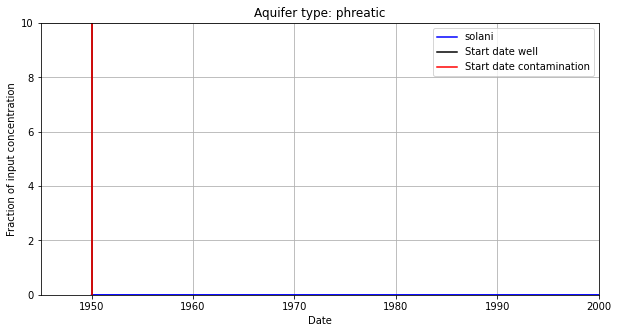

In [102]:
solani_plot = phreatic_transport.plot_concentration(ylim=[0,10 ], as_fraction_input = True)

You can also compute the removal for a different mbo of interest (plant pathogens):

* carotovorum
* solanacearum

Or optionally a different species of own choice (non-default):
* MS2 (virus)

To do so you can use the original schematisation, but specify a different mbo when you create the Transport object.

species: carotovorum (default)
-------------------------------

In [103]:
# First, rerun the model to recalculate df_particle and df_flowline
modpath_phrea.run_model(run_mfmodel = True,
                    run_mpmodel = True)


Run phreatic model
Run model: d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic

FloPy is using the following executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.9.01 5/01/2012                        

 Using NAME file: phreatic.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/07/28 10:33:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/28 10:33:34
 Elapsed run time:  0.045 Seconds

  Normal termination of simulation
Model run d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic completed without errors: True
Run modpath: d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic

FloPy is using the following executable to run the model: .\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compil

In [104]:
# removal parameters carotovorum (default)
organism_carotovorum = TR.MicrobialOrganism(organism_name = "carotovorum")
print(organism_carotovorum.organism_dict)

# Transport object
phreatic_transport = TR.Transport(modpath_phrea, pollutant = organism_carotovorum)
# keep track of final cocnentration per endpoint_id
C_final = {}
# Update df_flowline and df_particle. Calculate final concentration at endpoint_id(s)
for endpoint_id in endpoint_ids:
    df_particle, df_flowline, C_final[endpoint_id] = phreatic_transport.calc_advective_microbial_removal( 
                                                endpoint_id = endpoint_id)
    print(f"Final concentration {endpoint_id}: {C_final[endpoint_id]}")


{'organism_name': 'carotovorum', 'alpha0': {'suboxic': 0.3, 'anoxic': 0.577, 'deeply_anoxic': 0.577}, 'pH0': {'suboxic': 7.5, 'anoxic': 7.5, 'deeply_anoxic': 7.5}, 'organism_diam': 1.803e-06, 'mu1': {'suboxic': 1.2664, 'anoxic': 0.1279, 'deeply_anoxic': 0.1279}}
Final concentration well1: 0.0


In [105]:
# Plot the breakthrough concentration
carotovorum_plot = phreatic_transport.plot_concentration(ylim=2*C_final[endpoint_id]], as_fraction_input = True)

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (433262639.py, line 2)

species: solanacearum (default)
--------------------------------

In [ ]:
# First, rerun the model to recalculate df_particle and df_flowline
modpath_phrea.run_model(run_mfmodel = True,
                    run_mpmodel = True)


Run phreatic model
Run model: d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic

FloPy is using the following executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.9.01 5/01/2012                        

 Using NAME file: phreatic.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/07/28 10:24:46

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/28 10:24:46
 Elapsed run time:  0.040 Seconds

  Normal termination of simulation
Model run d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic completed without errors: True
Run modpath: d:\Sutra2_tool\sutra2\research\mpw_mboremoval phreatic

FloPy is using the following executable to run the model: .\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compil

In [ ]:

# removal parameters solanacearum (default)
organism_solanacearum = TR.MicrobialOrganism(organism_name = "solanacearum")
print(organism_solanacearum.organism_dict)

# Transport object
phreatic_transport = TR.Transport(modpath_phrea, pollutant = organism_solanacearum)
# keep track of final cocnentration per endpoint_id
C_final = {}
# Update df_flowline and df_particle. Calculate final concentration at endpoint_id(s)
for endpoint_id in endpoint_ids:
    df_particle, df_flowline, C_final[endpoint_id] = phreatic_transport.calc_advective_microbial_removal( 
                                                endpoint_id = endpoint_id)
    print(f"Final concentration {endpoint_id}: {C_final[endpoint_id]}")


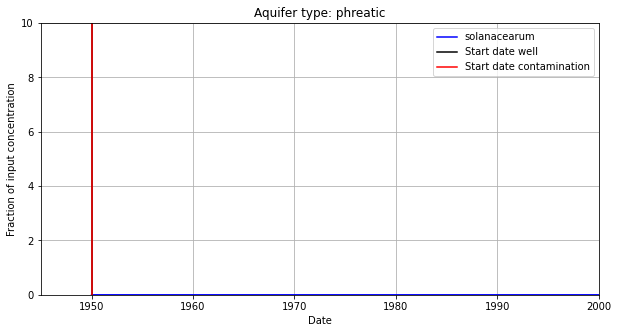

In [ ]:
solanacearum_plot = phreatic_transport.plot_concentration(ylim=2*C_final[endpoint_id]], as_fraction_input = True)

species: MS2 -virus (manual input)
-----------------------------------

Define removal parameters

In [ ]:
# microbial removal properties of microbial organism
organism_name = 'MS2'
# reference_collision_efficiency [-]
alpha0 = {"suboxic": 1.e-3, "anoxic": 1.e-5, "deeply_anoxic": 1.e-5}
# reference pH for calculating collision efficiency [-]
pH0 = {"suboxic": 6.6, "anoxic": 6.8, "deeply_anoxic": 6.8}
# diameter of pathogen/species [m]
organism_diam =  2.33e-8
# inactivation coefficient [1/day]
mu1 = {"suboxic": 0.149,"anoxic": 0.023,"deeply_anoxic": 0.023}
# removal parameters for MS2 (manual input MicrobialOrganism)
organism_MS2 = TR.MicrobialOrganism(organism_name = organism_name,
                                    alpha0_suboxic = alpha0["suboxic"],
                                    alpha0_anoxic = alpha0["anoxic"],
                                    alpha0_deeply_anoxic = alpha0["deeply_anoxic"],
                                    pH0_suboxic = pH0["suboxic"],
                                    pH0_anoxic = pH0["anoxic"],
                                    pH0_deeply_anoxic = pH0["deeply_anoxic"],
                                    mu1_suboxic = mu1["suboxic"],
                                    mu1_anoxic = mu1["anoxic"],
                                    mu1_deeply_anoxic = mu1["deeply_anoxic"],
                                    organism_diam = organism_diam)

In [ ]:
# First, rerun the model to recalculate df_particle and df_flowline
modpath_phrea.run_model(run_mfmodel = True,
                    run_mpmodel = True)

Call the transport object and calculate the mbo removal

In [ ]:
# Transport object
phreatic_transport = TR.Transport(modpath_phrea, pollutant = organism_MS2)
print(organism_MS2.organism_dict)

# keep track of final cocnentration per endpoint_id
C_final = {}
# Update df_flowline and df_particle. Calculate final concentration at endpoint_id(s)
for endpoint_id in endpoint_ids:
    df_particle, df_flowline, C_final[endpoint_id] = phreatic_transport.calc_advective_microbial_removal( 
                                                endpoint_id = endpoint_id)
    print(f"Final concentration {endpoint_id}: {C_final[endpoint_id]}")

{'organism_name': 'MS2', 'alpha0': {'suboxic': 0.001, 'anoxic': 1e-05, 'deeply_anoxic': 1e-05}, 'pH0': {'suboxic': 6.6, 'anoxic': 6.8, 'deeply_anoxic': 6.8}, 'organism_diam': 2.33e-08, 'mu1': {'suboxic': 0.149, 'anoxic': 0.023, 'deeply_anoxic': 0.023}}
Final concentration well1: 7.746518691818823e-40


Plot the breakthrough concentration

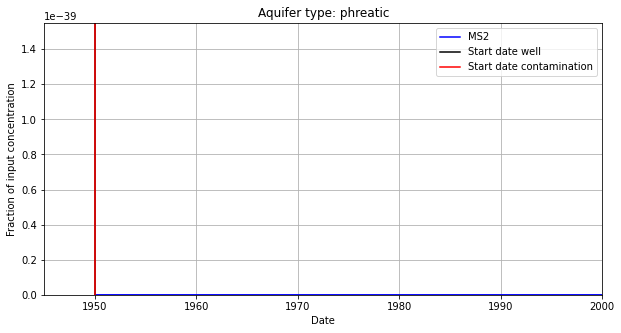

In [ ]:
MS2_plot = phreatic_transport.plot_concentration(ylim=[0,2*C_final[endpoint_id]], as_fraction_input = True)